# NEW YORK CITY TAXIS - ANALYSIS, RECOMMENDATIONS, PREDICTIONS

By Sergei Eremenko, Ph.D., Doctor of Engineering, https://www.linkedin.com/in/sergei-eremenko-3862079/, Sydney, Australia.

Around half a million taxi trips are made daily in the New York City that never sleeps. Largest in the world taxi network provides quite reliable and affordable services to residents and millions of tourists mainly targeting Manhattan area. Around 40K drivers compete for customers and can sustain their business by intuitively selecting optimal routes, pickup locations, working hours. Modern Data Science and Machine learning tools can help drivers, commuters, taxi companies and authorities to undertand traffic data patterns, main city clusters and provide some valuable recommendations on trip planning, best driver's working hours and areas, and online tools to identify the best hotspots.

The research hereafter consists of four parts and is based on free available data using data science tools like, R, Python, SQL, Tableau, Big Data concepts, and Machine Learning algorithms like linear and Random  Forest regressions, data clustering, predictive modelling, and usage of geomapping services like Google Maps.

# <font color="teal">PART 1 - DATA ANALYSIS</font>

This part of 4 parts-research is dedicated to analysing ~30 Mln of records for April 2013 NYC taxi trips to analyse distribution of main data features - locations, fares, tips, pickup and dropoff locations, payment types and others. This analysis will be used in next parts to build predictive models and provide recomendations.

## Objective.
Research of the following questions:
a. What is the distribution of number of passengers per trip? 
b. What is the distribution of payment_type? 
c. What is the distribution of fare amount? 
d. What is the distribution of tip amount? 
e. What is the distribution of total amount? 
f. What are top 5 busiest hours of the day? 
g. What are the top 10 busiest locations of the city? 
h. Which trip has the highest standard deviation of travel time? i. 
Which trip has most consistent fares? 

## Approach
Use R Data Analysis tools to construct different plots, clean and merge datasets, enrich data with Google Map locations, consolidate 
data to route areas rather than individual spots, and also use advanced data aggregation tools like Tableau to present data in effective way.

# 1.1. Read Data from files

In [ ]:
library(lubridate)
library('rlang')
library("ggplot2")
library("ggmap")
library(plyr)
library(pwr)
library("sqldf")

In [2]:
############### Read Data from files #################################
tripData <- read.csv("trip_data_4.csv")
head(tripData, 5)

medallion                        hack_license                     vendor_id
1 91F6EB84975BBC867E32CB113C7C2CD5 AD8751110E6292079EB10EB9481FE1A6 CMT      
2 EC34CD1B3797DFAFF3FE099BA87B6656 8FE6A4AEDF89B6B4E19D2377FD3FB7D7 CMT      
3 C1B9DA774DC2BBC6DE27CE994E7F44A0 E1B595FD55E4C82C1E213EB17438107A CMT      
4 9BA84250355AB3FC031C9252D395BF8A 16BB0D96A0DCC853AEC7F55C8D6C71E0 CMT      
5 205A696DF62AD03C88DA8C5EC5248639 579C41EA5EC846F8B641A42F9EE3E855 CMT      
  rate_code store_and_fwd_flag pickup_datetime     dropoff_datetime   
1 1         N                  2013-04-04 18:47:45 2013-04-04 19:00:25
2 1         N                  2013-04-05 07:08:34 2013-04-05 07:17:34
3 1         N                  2013-04-04 17:59:50 2013-04-04 18:21:48
4 1         N                  2013-04-04 18:12:01 2013-04-04 18:25:24
5 1         N                  2013-04-04 20:12:57 2013-04-04 20:29:55
  passenger_count trip_time_in_secs trip_distance pickup_longitude
1 1                759              2.5           -73.95785       
2 1                540              1.6             0.00000       
3 1               1318              3.6           -73.98288       
4 1                799              1.9           -73.97812       
5 1               1017              3.6           -74.00637       
  pickup_latitude dropoff_longitude dropoff_latitude
1 40.76532        -73.97627         40.78565        
2  0.00000          0.00000          0.00000        
3 40.75499        -74.00919         40.71537        
4 40.76345        -73.95567         40.77664        
5 40.74475        -73.96166         40.76108

In [3]:
tripFare <- read.csv("trip_fare_4.csv")
head(tripFare, 5)

medallion                        hack_license                     vendor_id
1 91F6EB84975BBC867E32CB113C7C2CD5 AD8751110E6292079EB10EB9481FE1A6 CMT      
2 EC34CD1B3797DFAFF3FE099BA87B6656 8FE6A4AEDF89B6B4E19D2377FD3FB7D7 CMT      
3 C1B9DA774DC2BBC6DE27CE994E7F44A0 E1B595FD55E4C82C1E213EB17438107A CMT      
4 9BA84250355AB3FC031C9252D395BF8A 16BB0D96A0DCC853AEC7F55C8D6C71E0 CMT      
5 205A696DF62AD03C88DA8C5EC5248639 579C41EA5EC846F8B641A42F9EE3E855 CMT      
  pickup_datetime     payment_type fare_amount surcharge mta_tax tip_amount
1 2013-04-04 18:47:45 CRD          11.0        1.0       0.5     2.50      
2 2013-04-05 07:08:34 CRD           8.5        0.0       0.5     1.80      
3 2013-04-04 17:59:50 CRD          16.5        1.0       0.5     3.60      
4 2013-04-04 18:12:01 CRD          10.0        1.0       0.5     3.45      
5 2013-04-04 20:12:57 CRD          15.0        0.5       0.5     3.20      
  tolls_amount total_amount
1 0            15.00       
2 0            10.80       
3 0            21.60       
4 0            14.95       
5 0            19.20

# 1.2. Cleanse data

In [4]:
between <- function(num, num1, num2) {
    # check whether a number is betwen bounds
    return ((num >= num1) & (num <= num2))
}

In [5]:
# Clean up tripData
tripData <- subset(tripData, between(pickup_longitude, -80,  -70) & between(pickup_latitude, 35, 45)) # Wrong location
tripData <- subset(tripData, between(dropoff_longitude, -80, -70) & between(dropoff_latitude, 35, 45))
tripData <- subset(tripData, trip_distance > 0)
tripData <- subset(tripData, trip_time_in_secs > 0)

tripData$store_and_fwd_flag <- NULL
tripData$rate_code <- NULL

In [6]:
# Clean up tripFare
tripFare$surcharge <- NULL
tripFare$mta_tax <- NULL
tripFare$tolls_amount <- NULL

tripFare <- subset(tripFare, total_amount > 0 & fare_amount > 0 & tip_amount >= 0)

# 1.3. Data features distributions

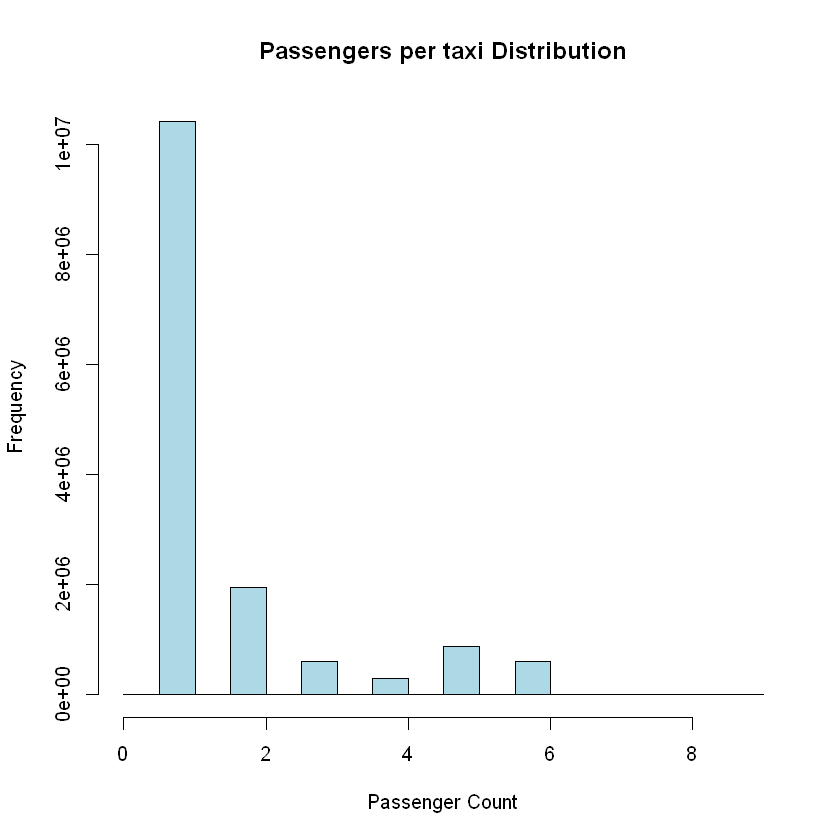

In [7]:
# Distribution of Passengers
hist(tripData$passenger_count, xlab="Passenger Count", main = "Passengers per taxi Distribution", col="lightblue")

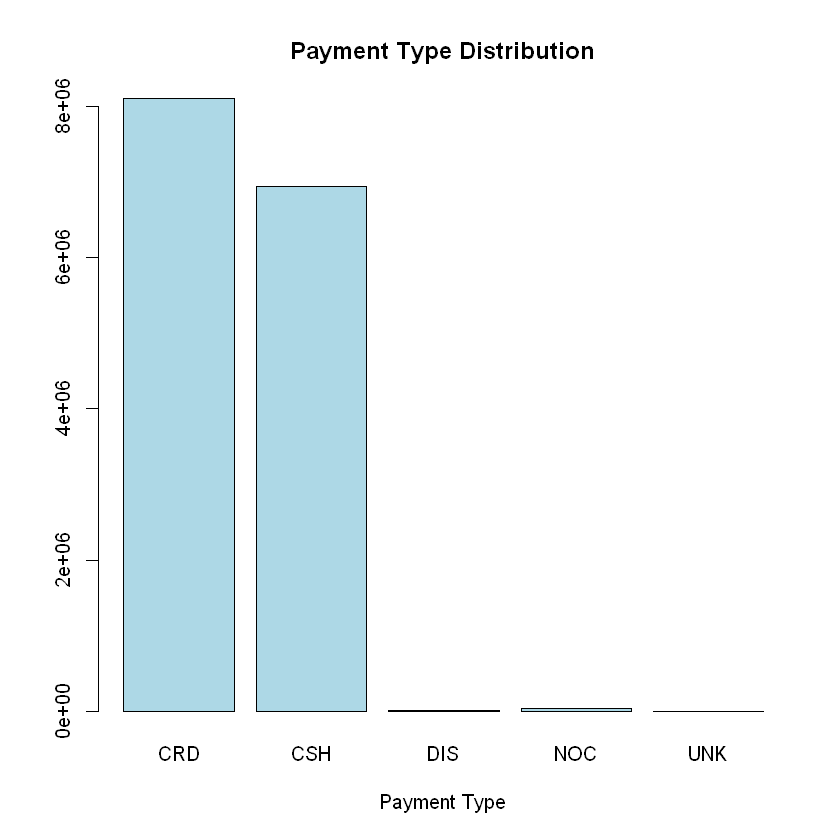

In [8]:
# Distribution of Payment Type
barplot(table(tripFare$payment_type), xlab="Payment Type", main = "Payment Type Distribution", col="lightblue")

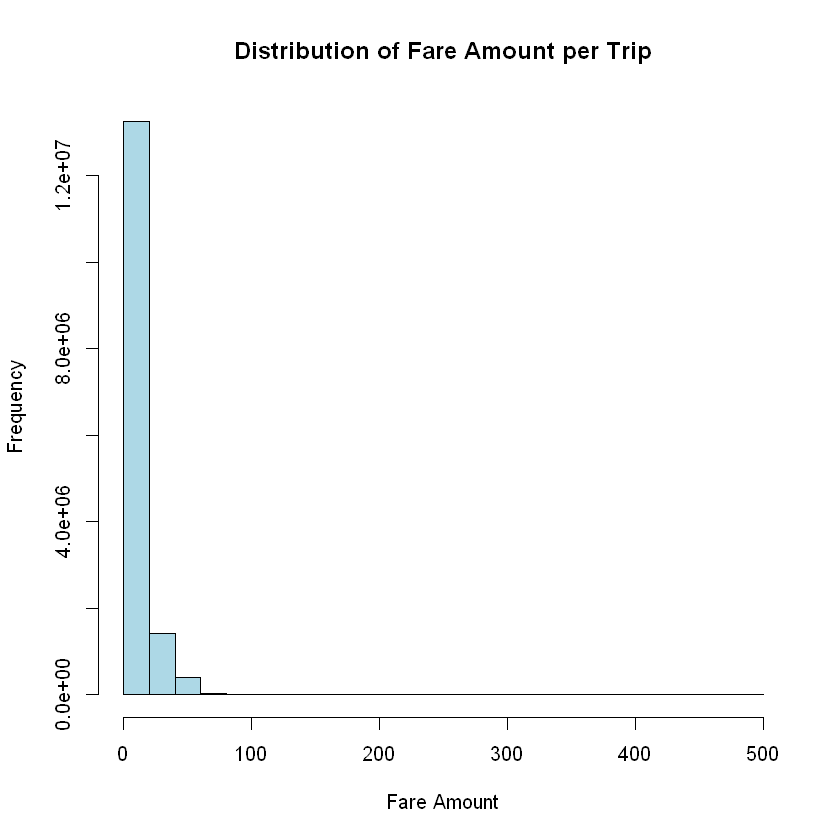

In [9]:
# Distribution of Fare Amount
hist(tripFare$fare_amount, xlab="Fare Amount", main = "Distribution of Fare Amount per Trip", col="lightblue")

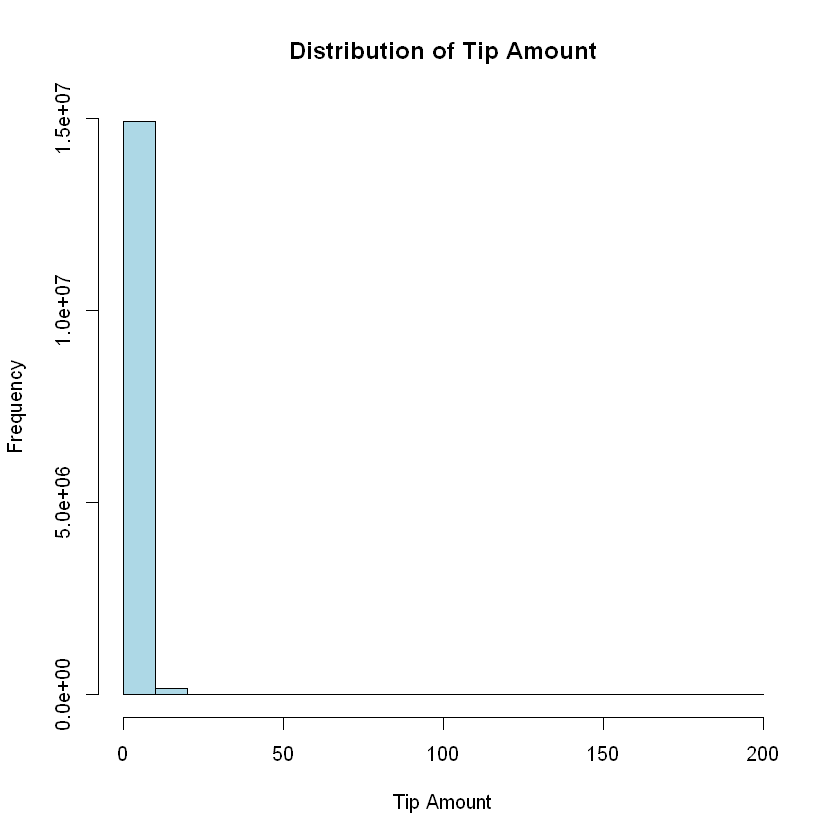

In [10]:
# Distribution of Tip Amount
hist(tripFare$tip_amount, xlab="Tip Amount", main = "Distribution of Tip Amount", col="lightblue")

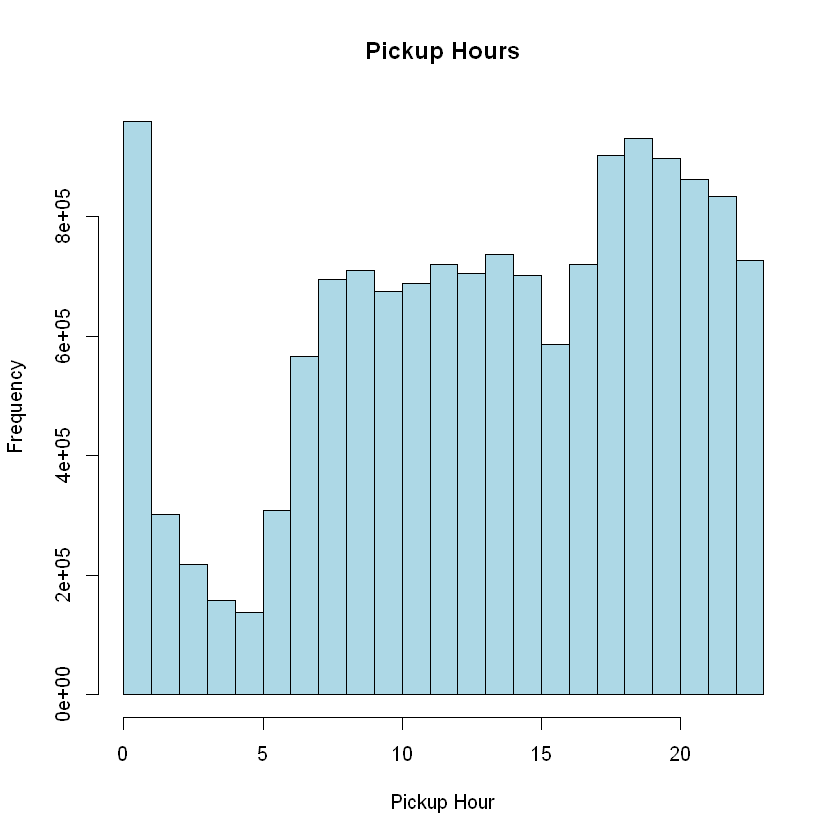

In [11]:
# Distribution of hours
hours <- hist(lubridate::hour(tripData$pickup_datetime), xlab="Pickup Hour", main = "Pickup Hours", col="lightblue")
#plot(hours)

# 1.4. Data Analysis

## Helper function - Extracting location addresses from Google Maps

In [12]:
LocationAddress <- function(long, lat)
{
    # Extract location address from Google mapps
    #
  res <- ""
  if ((is.numeric(long) && is.numeric(lat)) && (long != 0 && lat != 0)) {
    geo <- ggmap::revgeocode(c(long, lat), output="more", messaging = FALSE)
    if (length(geo) > 0) {
      res <- as.character(geo$address)
    }
  }
  return(res)
}

## 1.4.1. Busiest Hours

In [13]:
# 5 Busiest Hours - Extract data from histogram object
BusiestHours <- order(hours$counts, decreasing = TRUE)[1:5]
print(BusiestHours)

[1]  1 19 18 20 21


## 1.4.2. Busiest Locations

### 1.4.2.1. Find busiest dropoff locations

In [ ]:
FindBusiestPickups <- function (nofPickups = 10) 
{
  # Find counters of valid pickups
  pickups <- plyr::count(tripData, c('pickup_longitude', 'pickup_latitude'))
  # Select Top 10 of Busiest locations
  return (pickups[order(pickups$freq, decreasing = TRUE),][1:nofPickups,])
}
BusiestPickups <- FindBusiestPickups(10)

# Enrich Data with Addresses from Google Maps
BusiestPickups$address <- NA
for (j in 1:4) # This block needs to be executed twice to overcome Google Maps limitations on number of calls
{
  for (i in 1:nrow(BusiestPickups)) 
  {
    if (is.na(BusiestPickups$address[i]))
        BusiestPickups$address[i] <- LocationAddress(BusiestPickups$pickup_longitude[i], BusiestPickups$pickup_latitude[i])
  }
}

In [15]:
BusiestPickups

pickup_longitude pickup_latitude freq
19910   -74.02305        40.76599        6814
516466  -73.99094        40.73605         848
525886  -73.94904        40.74491         843
773724  -73.91736        40.67056         390
714294  -73.88363        40.63221         238
540070  -74.19521        40.54847         155
5135870 -73.96501        40.75566         129
530128  -73.98554        40.72207          92
1045484 -73.95411        40.75062          85
548024  -73.97285        40.72486          80
        address                                                     
19910   Lincoln Tunnel & Park Ave & NJ-495, Weehawken, NJ 07086, USA
516466  19 Union Square W, New York, NY 10003, USA                  
525886  11-49 47th Ave, Long Island City, NY 11101, USA             
773724  1521-1537 Eastern Pkwy, Brooklyn, NY 11233, USA             
714294  Shore Pkwy, Brooklyn, NY 11236, USA                         
540070  72 Green Valley Rd, Staten Island, NY 10312, USA            
5135870 961 1st Avenue, New York, NY 10022, USA                     
530128  242 E Houston St, New York, NY 10009, USA                   
1045484 4400 Vernon Blvd, Long Island City, NY 11101, USA           
548024  11 FDR Drive, New York, NY 10009, USA

### 1.4.2.2. Find busiest dropoff locations

In [ ]:
FindBusiestDropoffs <- function (nofRecords = 10)
  # Find Top Dropoff locations
{  
  dropoffs <- plyr::count(tripData, c('dropoff_longitude', 'dropoff_latitude'))
  # Select Top 10 of Busiest locations
  return (dropoffs[order(dropoffs$freq, decreasing = TRUE),][1:nofRecords,])
}

BusiestDropoffs <- FindBusiestDropoffs()

# Enrich Data with Addresses from Google Maps
BusiestDropoffs$address <- NA
for (j in 1:5) # This block needs to be executed twice to overcome Google Maps limitations on number of calls
{
  for (i in 1:nrow(BusiestDropoffs))
  {
    if (is.na(BusiestDropoffs$address[i]))
      BusiestDropoffs$address[i] <- LocationAddress(BusiestDropoffs$dropoff_longitude[i], BusiestDropoffs$dropoff_latitude[i])
  }
}

In [17]:
BusiestDropoffs

dropoff_longitude dropoff_latitude freq
20117   -74.02305         40.76599         6994
543931  -73.99094         40.73605          848
553614  -73.94904         40.74491          843
804623  -73.91736         40.67056          389
744423  -73.88363         40.63221          238
568142  -74.19521         40.54847          155
5478542 -73.96501         40.75566          128
558016  -73.98554         40.72207           90
1081441 -73.95411         40.75062           86
576247  -73.97285         40.72486           79
        address                                                     
20117   Lincoln Tunnel & Park Ave & NJ-495, Weehawken, NJ 07086, USA
543931  19 Union Square W, New York, NY 10003, USA                  
553614  11-49 47th Ave, Long Island City, NY 11101, USA             
804623  1521-1537 Eastern Pkwy, Brooklyn, NY 11233, USA             
744423  Shore Pkwy, Brooklyn, NY 11236, USA                         
568142  72 Green Valley Rd, Staten Island, NY 10312, USA            
5478542 961 1st Avenue, New York, NY 10022, USA                     
558016  242 E Houston St, New York, NY 10009, USA                   
1081441 4400 Vernon Blvd, Long Island City, NY 11101, USA           
576247  11 FDR Drive, New York, NY 10009, USA

### 1.4.2.3. Find busiest pickup City Areas 

In [ ]:
gc()
FindBuisestPickupAreas <- function (nofRecords = 10) 
  # IdentifyTop Pickup Areas rounding geolocation to larger area excluding the same pickup and dropoffs
{
  trips <- subset(sqldf("SELECT ROUND(pickup_longitude, 3) as p_long, ROUND(pickup_latitude, 3) as p_lat, 
                         COUNT(*) AS num_trips
                         FROM tripData
                         GROUP BY p_long, p_lat
                         ORDER BY num_trips DESC"
  ))
  return(trips[1:nofRecords,])
}
BusiestPickupAreas <- FindBuisestPickupAreas(10)

# Enrich Data with Addresses from Google Maps
BusiestPickupAreas$address <- NA
for (j in 1:4) # This block needs to be executed twice to overcome Google Maps limitations on number of calls
{
  for (i in 1:nrow(BusiestPickupAreas)) 
  {
    if (is.na(BusiestPickupAreas$address[i]))
      BusiestPickupAreas$address[i] <- LocationAddress(BusiestPickupAreas$p_long[i], BusiestPickupAreas$p_lat[i])
  }
}

In [19]:
BusiestPickupAreas

p_long  p_lat  num_trips
1  -73.994 40.751 64703    
2  -73.863 40.769 56802    
3  -73.992 40.750 56453    
4  -73.991 40.750 54079    
5  -73.871 40.774 51260    
6  -73.873 40.774 47131    
7  -73.990 40.757 38992    
8  -73.991 40.756 37981    
9  -73.978 40.752 37535    
10 -73.782 40.645 34278    
   address                                                            
1  Pennsylvania Station, 4 Pennsylvania Plaza, New York, NY 10001, USA
2  Delta Departures Rd, East Elmhurst, NY 11371, USA                  
3  2 Pennsylvania Plaza, New York, NY 10121, USA                      
4  401 7th Ave, New York, NY 10001, USA                               
5  Terminal B, Queens, NY 11371, USA                                  
6  1 Central Terminal Dr, Flushing, NY 11371, USA                     
7  625-659 8th Ave, New York, NY 10018, USA                           
8  300 W 40th St, New York, NY 10018, USA                             
9  124 Park Ave, New York, NY 10016, USA                              
10 Van Wyck Expy, Jamaica, NY 11430, USA

### 1.4.2.4. Find busiest dropoff pickup City Areas

In [ ]:
FindBuisestDropoffAreas <- function (nofRecords = 10) 
  # IdentifyTop Dropoff Areas rounding geolocation to larger area
{
  trips <- subset(sqldf("SELECT ROUND(dropoff_longitude, 3) as d_long, ROUND(dropoff_latitude, 3) as d_lat, 
                        COUNT(*) AS num_trips
                        FROM tripData
                        GROUP BY d_long, d_lat
                        ORDER BY num_trips DESC"
  ))
  return(trips[1:nofRecords,])
}
BusiestDropoffAreas <- FindBuisestDropoffAreas(10)

# Enrich Data with Addresses from Google Maps
BusiestDropoffAreas$address <- NA
for (j in 1:5) # This block needs to be executed twice to overcome Google Maps limitations on number of calls
{
  for (i in 1:nrow(BusiestDropoffAreas)) 
  {
    if (is.na(BusiestDropoffAreas$address[i]))
      BusiestDropoffAreas$address[i] <- LocationAddress(BusiestDropoffAreas$d_long[i], BusiestDropoffAreas$d_lat[i])
  }
}

In [37]:
BusiestDropoffAreas

d_long  d_lat  num_trips address                                      
1  -73.991 40.750 60175     401 7th Ave, New York, NY 10001, USA         
2  -73.995 40.750 45652     412 8th Ave, New York, NY 10001, USA         
3  -73.992 40.749 44823     371-379 7th Ave, New York, NY 10001, USA     
4  -73.991 40.751 44049     202 W 34th St, New York, NY 10119, USA       
5  -73.871 40.774 27748     Terminal B, Queens, NY 11371, USA            
6  -73.979 40.762 26690     1319-1325 6th Ave, New York, NY 10019, USA   
7  -73.978 40.752 26489     124 Park Ave, New York, NY 10016, USA        
8  -73.992 40.750 24687     2 Pennsylvania Plaza, New York, NY 10121, USA
9  -73.990 40.757 24583     625-659 8th Ave, New York, NY 10018, USA     
10 -73.977 40.752 23976     107 E 42 St Ext, New York, NY 10017, USA

## 1.4.3. Routes with the highest Standard Deviation of Travel Time

### Helper function - Calculate minimal sample size based on Confidence Intervals

In [38]:
CalcSampleSize <- function(method = "defaultValue", sigLevel = 0.05) {
  # Calculate minimal sample size observations (https://en.wikipedia.org/wiki/Sample_size_determination)
  samplesize <- 0
  #print(method)
  if (method == "defaultValue")
    samplesize <- 30 # Recommended by "Applied Statistics for Engineers and Scientists" book
  else if (method == "minValue")
    samplesize <- 9 # For rare events
  else if (method == "anova")
    samplesize = as.integer(pwr.anova.test(k=5, f=0.25, sig.level=sigLevel, power=0.7)$n)
  else if (method == "ttest")
    samplesize = as.integer(pwr.t.test(d=0.75, power=0.7, sig.level=sigLevel, alternative="greater")$n)

  return(samplesize)
}

### 1.4.3.1. Explore minimal sample sizes algorithms

In [39]:
print( CalcSampleSize(method = "minValue"))
print( CalcSampleSize(method = "defaultValue"))
print( CalcSampleSize(method = "anova"))
print( CalcSampleSize(method = "ttest", 0.01))

[1] 9
[1] 30
[1] 31
[1] 30


In [40]:
## Accept min sample size due to rarity of events of the same pickup and dropoff
minObservations <- CalcSampleSize(method = "minValue") 
minObservations

[1] 9

### 1.4.3.2. Find statistically significant repeated trips

In [41]:
gc() # Free some memory

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   3356829  179.3  10302128   550.2  16726122  893.3
Vcells 242358625 1849.1 604845272  4614.7 604845272 4614.7

In [42]:
#####################################################################################################################
FindRepeatedTrips <- function (minObservations = 9)
    # Identify Repeated Trips with calculation of deviations
{
  trips <- subset(sqldf(sprintf("SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, 
                        COUNT(*) AS num_trips,
                        AVG(trip_time_in_secs) AS avg_time,
                        STDEV(trip_time_in_secs) AS sd_time,
                        STDEV(trip_time_in_secs)/AVG(trip_time_in_secs) AS variation
                        FROM tripData
                        WHERE trip_time_in_secs > 0
                        GROUP BY pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
                        HAVING COUNT(*) >= %s 
                        ORDER BY variation DESC", minObservations)
  ))
  return(trips)
}
trips <- FindRepeatedTrips(minObservations = 2)

In [43]:
head(trips,5)
nrow(trips)
# Comment - observe not many (<3K) repeated trips with EXACT matches of locations

pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude num_trips
1 -73.93376        40.75265        -73.93376         40.75265         6        
2 -73.90952        40.73760        -73.90952         40.73760         5        
3 -73.90057        40.75623        -73.90057         40.75623         3        
4 -73.96452        40.75029        -73.96452         40.75029         3        
5 -73.96343        40.75773        -73.96343         40.75773         6        
  avg_time  sd_time   variation
1 1067.5000 1726.7355 1.617551 
2  884.8000 1422.3541 1.607543 
3  500.0000  762.1024 1.524205 
4 1204.6667 1793.2558 1.488591 
5  713.3333 1061.2194 1.487691

[1] 14651

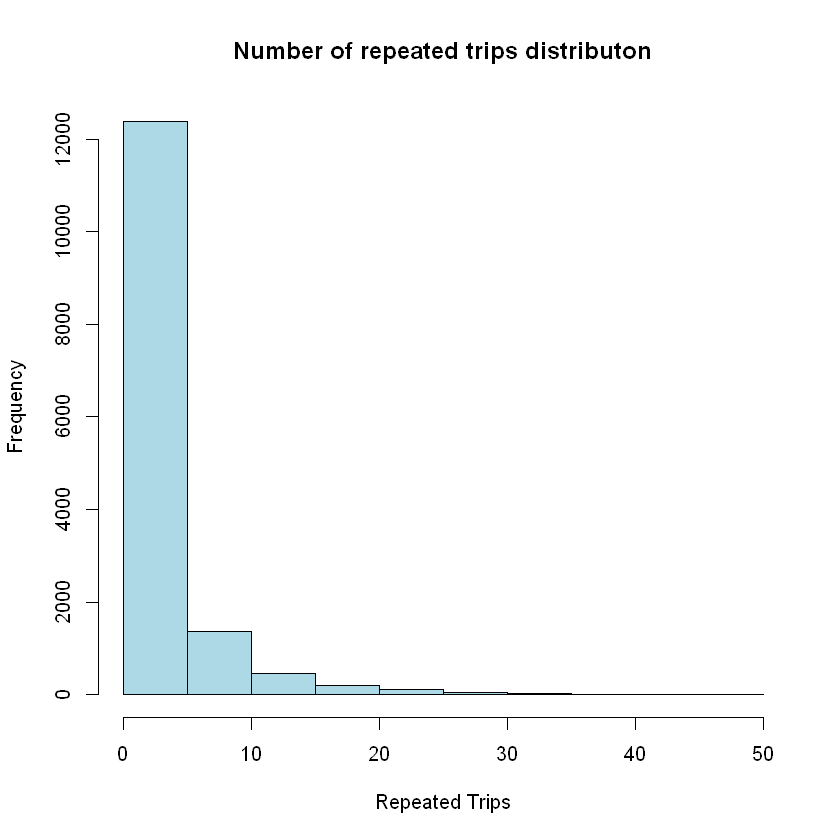

In [44]:
hist(trips$num_trips[trips$num_trips<50], xlab="Repeated Trips", main = "Number of repeated trips distributon", 
     col="lightblue")

### <font color="darkblue">To find repeated routes, it makes sense to consolidate trips based on approx locations</font>

In [45]:
FindRepeatedTripAreas <- function (minObservations = 9)
    # Identify Repeated Trips with calculation of deviations
{
  trips <- subset(sqldf(sprintf("SELECT ROUND(pickup_longitude, 2) AS p_long, ROUND(pickup_latitude, 2) as p_lat, 
                                ROUND(dropoff_longitude, 2) AS d_long, ROUND(dropoff_latitude, 2) as d_lat,
                                COUNT(*) AS num_trips,
                                AVG(trip_time_in_secs) AS avg_time,
                                STDEV(trip_time_in_secs) AS sd_time,
                                STDEV(trip_time_in_secs)/AVG(trip_time_in_secs) AS variation
                                FROM tripData
                                WHERE trip_time_in_secs > 0
                                GROUP BY p_long, p_lat, d_long, d_lat
                                HAVING COUNT(*) >= %s
                                ORDER BY variation DESC", minObservations)
  ))
  return(trips)
}
minSamples = CalcSampleSize(method = "defaultValue")
trips <- FindRepeatedTripAreas(minObservations = minSamples)

In [46]:
head(trips,5)
# Observation -> the most volatile trip times in trips between close locations

p_long p_lat d_long d_lat num_trips avg_time sd_time   variation
1 -74.18 40.70 -74.18 40.70  66       135.1515  474.3258 3.509585 
2 -73.78 40.65 -73.78 40.65 675       256.1333  707.7820 2.763334 
3 -73.78 40.64 -73.78 40.65 229       408.4105 1052.1024 2.576091 
4 -73.78 40.65 -73.79 40.65 232       618.4914 1534.6673 2.481307 
5 -73.79 40.64 -73.79 40.64 794       480.7519 1171.1625 2.436106

### 1.4.3.3. The busiest statistically significant repeated route areas

In [47]:
BusiestRoutes = trips[order(trips$num_trips, decreasing = TRUE),]
head(BusiestRoutes, 10)
nrow(BusiestRoutes)

p_long p_lat d_long d_lat num_trips avg_time sd_time  variation
942  -73.99 40.75 -73.98 40.76 79071     551.2920 302.7663 0.5491941
1138 -73.97 40.76 -73.96 40.77 67210     351.3046 180.9726 0.5151444
1198 -73.96 40.77 -73.97 40.76 66364     467.0770 236.7039 0.5067770
1163 -73.98 40.76 -73.99 40.75 66144     516.5106 263.9786 0.5110807
1077 -73.97 40.76 -73.98 40.75 64503     466.1071 245.0187 0.5256703
1172 -73.98 40.75 -73.97 40.76 62223     458.1412 233.6842 0.5100703
1009 -73.99 40.75 -73.98 40.75 61856     483.7741 259.8535 0.5371382
1074 -73.98 40.75 -73.99 40.75 58960     473.0687 248.7903 0.5259073
1085 -73.99 40.74 -73.98 40.75 56850     447.3280 234.1943 0.5235403
901  -73.97 40.76 -73.98 40.76 55879     506.2535 281.7051 0.5564506

[1] 13263

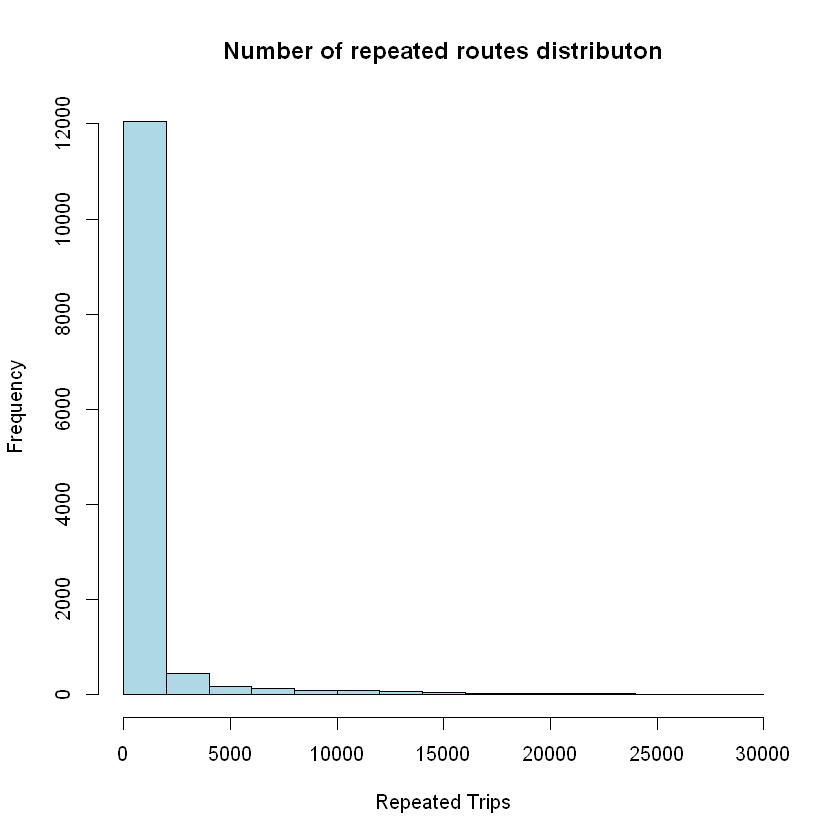

In [48]:
hist(trips$num_trips[trips$num_trips < 30000], xlab="Repeated Trips", 
     main = "Number of repeated routes distributon", col="lightblue")

In [49]:
### The areas with the biggest variation of travel time
mostVolatileTripArea <- trips[1,]
print(mostVolatileTripArea)

  p_long p_lat d_long d_lat num_trips avg_time  sd_time variation
1 -74.18  40.7 -74.18  40.7        66 135.1515 474.3258  3.509585


In [50]:
# Show trips inside the most volatile routes area
mostVolatileTrips <- subset(tripData, (round(pickup_longitude, 2) == mostVolatileTripArea$p_long) &
                      (round(pickup_latitude, 2) == mostVolatileTripArea$p_lat) &
                      (round(dropoff_longitude,2) == mostVolatileTripArea$d_long) &
                      (round(dropoff_latitude, 2) == mostVolatileTripArea$d_lat))
head(mostVolatileTrips)
nrow(mostVolatileTrips)

medallion                        hack_license                    
674059  45886CDFD76DF25E0ACA5E3ED611C68E 410FEF683E325F4832B683461183B00B
844087  84FDB559CA0A69FDBB6D87A3EB319DB7 334A65DEAB3A0C1311111A8484F27DF3
867056  87077D0B254D4966BE39E9D973D603C6 4D7579A8DB8433B5B0F83ED294566AF3
1060691 C858370565D28E75940B435828ED116C 43C8C49BBD2C73B0A8F9CA13CE6DEFA2
1060792 C858370565D28E75940B435828ED116C 43C8C49BBD2C73B0A8F9CA13CE6DEFA2
1089062 D115D4D9F1064C1297429028BA650887 9AE7CE9037B0DACBD4D99AD1A5529C3A
        vendor_id pickup_datetime     dropoff_datetime    passenger_count
674059  CMT       2013-04-21 14:53:00 2013-04-21 14:53:00 1              
844087  CMT       2013-04-19 11:28:00 2013-04-19 11:29:00 1              
867056  CMT       2013-04-22 15:03:00 2013-04-22 15:03:00 3              
1060691 CMT       2013-04-16 13:17:00 2013-04-16 13:17:00 1              
1060792 CMT       2013-04-16 13:16:00 2013-04-16 13:16:00 1              
1089062 CMT       2013-04-19 15:48:00 2013-04-19 15:50:00 1              
        trip_time_in_secs trip_distance pickup_longitude pickup_latitude
674059   1                 6.2          -74.17720        40.69515       
844087  13                 4.5          -74.17763        40.69547       
867056  28                 0.7          -74.17731        40.69508       
1060691 13                14.0          -74.17714        40.69513       
1060792  3                14.0          -74.17709        40.69508       
1089062 90                 4.7          -74.17780        40.69531       
        dropoff_longitude dropoff_latitude
674059  -74.17719         40.69515        
844087  -74.17760         40.69549        
867056  -74.17736         40.69511        
1060691 -74.17714         40.69512        
1060792 -74.17709         40.69508        
1089062 -74.17786         40.69524

[1] 66

In [51]:
# Find one the most volatile trip
FindMostVolatileTrip <- function (minObservations = 1)
    # Identify Trips within the most volatile routes
{
  trips <- subset(sqldf(sprintf("SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude,
                                COUNT(*) AS num_trips,
                                AVG(trip_time_in_secs) AS avg_time,
                                STDEV(trip_time_in_secs) AS sd_time,
                                STDEV(trip_time_in_secs)/AVG(trip_time_in_secs) AS variation
                                FROM tripData
                                WHERE trip_time_in_secs > 0
                                GROUP BY pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
                                HAVING COUNT(*) >= %s
                                ORDER BY variation DESC", minObservations)
  ))
  return(trips[1,])
}
minSamples = CalcSampleSize(method = "minValue") # For one the most volatile trip it should be rear event sample size
mostVolatileTrip <- FindMostVolatileTrip(minObservations = minSamples)

In [52]:
mostVolatileTrip
# Observe -> most volatile repeated trip is from the same picku and dropoff location

pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude num_trips
1 -73.93944        40.75171        -73.93944         40.75171         10       
  avg_time sd_time  variation
1 996      1374.685 1.380206

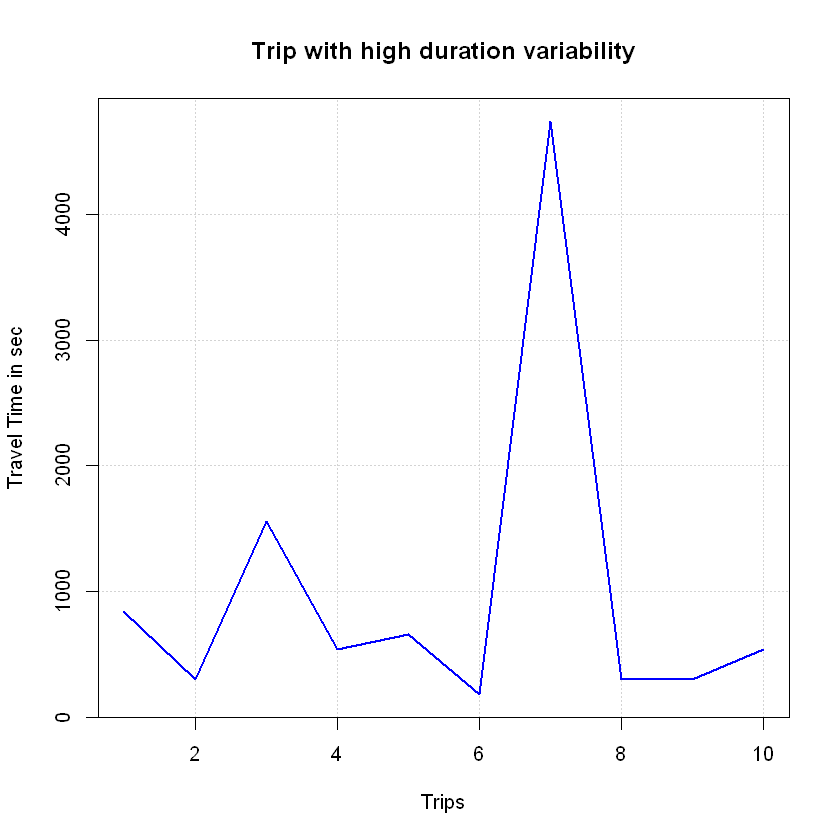

In [53]:
# Plot durations of the most volatile repeated trip
plot(subset(tripData, (pickup_longitude == mostVolatileTrip$pickup_longitude) &
              (pickup_latitude == mostVolatileTrip$pickup_latitude) &
              (dropoff_longitude == mostVolatileTrip$dropoff_longitude) &
              (dropoff_latitude == mostVolatileTrip$dropoff_latitude))
              $trip_time_in_secs,
     type="l", lwd=2, col="Blue", xlab="Trips", panel.first=grid(),
     ylab = "Travel Time in sec", main = "Trip with high duration variability")

In [54]:
rm(trips)
gc() # Free some memory

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   3359629  179.5  10302128   550.2  16726122  893.3
Vcells 242267032 1848.4 604845272  4614.7 604845272 4614.7

# 1.5. Merge Trip and Fare data into one dataset

In [55]:
gc()
# Purge unnecessary columns before merge
#tripData$passenger_count    <- NULL
#tripData$payment_type       <- NULL
tripData$rate_code          <- NULL
tripData$store_and_fwd_flag <- NULL

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   3359473  179.5  10302128   550.2  16726122  893.3
Vcells 242266999 1848.4 604845272  4614.7 604845272 4614.7

In [56]:
MergeData <- function() {
  # Merge data trip and fare data in one dataset
  #
  trips <- plyr::join(tripData, tripFare, by = NULL, type = "inner", match = "all")
  head(trips, 3)
  
  # Remove unnnecessary columns
  trips$passenger_count <- NULL
  trips$payment_type <- NULL
  trips$rate_code <- NULL
  trips$store_and_fwd_flag <- NULL
  trips$vendor_id <- NULL
  trips$medallion <- NULL
  
  # Enrich with hourly/weekly data
  trips$pickup_hour <- lubridate::hour(trips$pickup_datetime)
  trips$pickup_weekday <- lubridate::wday(trips$pickup_datetime)
  
  return(trips)
}
trips <- MergeData()
head(trips)

Joining by: medallion, hack_license, vendor_id, pickup_datetime


hack_license                     pickup_datetime     dropoff_datetime   
1 AD8751110E6292079EB10EB9481FE1A6 2013-04-04 18:47:45 2013-04-04 19:00:25
2 E1B595FD55E4C82C1E213EB17438107A 2013-04-04 17:59:50 2013-04-04 18:21:48
3 16BB0D96A0DCC853AEC7F55C8D6C71E0 2013-04-04 18:12:01 2013-04-04 18:25:24
4 579C41EA5EC846F8B641A42F9EE3E855 2013-04-04 20:12:57 2013-04-04 20:29:55
5 1B4E92431F9DA4D49874EC76E769E874 2013-04-05 02:48:11 2013-04-05 02:51:21
6 BC7B6E5A0132450CAE072F3C8F60BBE4 2013-04-05 06:16:10 2013-04-05 06:22:05
  trip_time_in_secs trip_distance pickup_longitude pickup_latitude
1  759              2.5           -73.95785        40.76532       
2 1318              3.6           -73.98288        40.75499       
3  799              1.9           -73.97812        40.76345       
4 1017              3.6           -74.00637        40.74475       
5  189              0.7           -73.98519        40.75493       
6  354              1.2           -73.98517        40.76342       
  dropoff_longitude dropoff_latitude fare_amount tip_amount total_amount
1 -73.97627         40.78565         11.0        2.50       15.00       
2 -74.00919         40.71537         16.5        3.60       21.60       
3 -73.95567         40.77664         10.0        3.45       14.95       
4 -73.96166         40.76108         15.0        3.20       19.20       
5 -73.99078         40.74800          4.5        1.10        6.60       
6 -73.97887         40.75114          6.5        1.00        8.00       
  pickup_hour pickup_weekday
1 18          5             
2 17          5             
3 18          5             
4 20          5             
5  2          6             
6  6          6

In [57]:
# Write consolidated data to file for further use in other notebooks
write.csv(trips, file = "trips_notebook.csv")

# 1.6. Find a trip with the most consistent fares

In [58]:
# Free resources
rm(tripFare)
rm(tripData)
gc()

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   3362086  179.6  19955956  1065.8  24944945 1332.3
Vcells 202195950 1542.7 696922552  5317.1 870244518 6639.5

In [59]:
#####################################################################################################################
FindRepeatedTripsWithFares <- function (minObservations = 9)
    # Identify Repeated Trips with calculation of deviations
{
  trips <- subset(sqldf(sprintf("SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, 
                        COUNT(*) AS num_trips,
                        AVG(fare_amount) AS avg_fare,
                        STDEV(fare_amount) AS sd_fare,
                        STDEV(fare_amount)/AVG(fare_amount) AS variation
                        FROM trips
                        WHERE fare_amount > 0
                        GROUP BY pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
                        HAVING COUNT(*) >= %s 
                        ORDER BY variation", minObservations)
  ))
  return(trips[1:5,]) ## return a few rows for analysis
}
minSamples = CalcSampleSize(method = "minValue") # For one the most volatile trip it should be rear event sample size
repTrips <- FindRepeatedTripsWithFares(minSamples)
head(repTrips)

pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude num_trips
1 -74.02082        40.64133        -74.02082         40.64133         12       
2 -73.95122        40.76396        -73.95122         40.76396          9       
3 -74.00385        40.72234        -74.00385         40.72234          9       
4 -73.95515        40.82027        -73.95515         40.82027          9       
5 -73.98220        40.77373        -73.98220         40.77373          9       
  avg_fare  sd_fare  variation
1  8.500000 1.461630 0.1719565
2  6.388889 1.111805 0.1740217
3  8.888889 1.691482 0.1902917
4 11.666667 2.263846 0.1940440
5 10.000000 2.000000 0.2000000

In [60]:
mostStableFareTrip <- repTrips[1,]

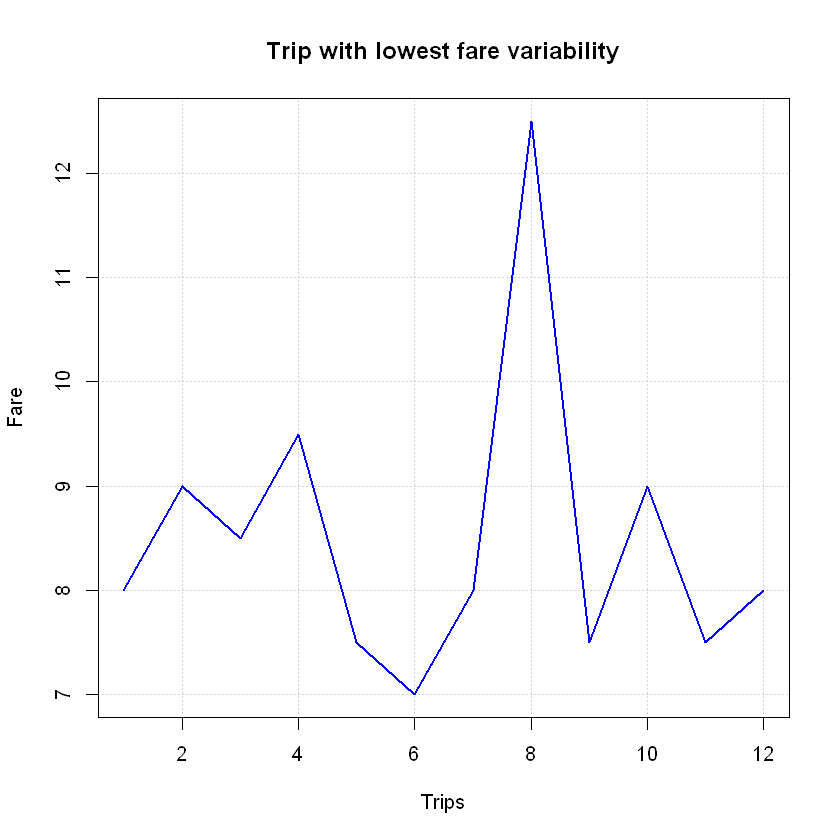

In [61]:
# Plot fares of the most stable fare repeated trip
plot(subset(trips, (pickup_longitude == mostStableFareTrip$pickup_longitude) &
              (pickup_latitude == mostStableFareTrip$pickup_latitude) &
              (dropoff_longitude == mostStableFareTrip$dropoff_longitude) &
              (dropoff_latitude == mostStableFareTrip$dropoff_latitude))
              $fare_amount,
     type="l", lwd=2, col="Blue", xlab="Trips", panel.first=grid(),
     ylab = "Fare", main = "Trip with lowest fare variability")

In [62]:
mostStableFareTrip

pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude num_trips
1 -74.02082        40.64133        -74.02082         40.64133         12       
  avg_fare sd_fare variation
1 8.5      1.46163 0.1719565

## 1.7. External Visualisation tools - TABLEAU

The images below produced in TableAU and will be visible if this Notebook run from Jupyter. The images can also be visible from the Tableau public location https://public.tableau.com/profile/soliton.scientific

### 1.7.1. Visualisation of Pickups per Hour/Weekday

<img src="PickupByHour.png" />

### 1.7.2. Visualisation of Best Working Hours

<img src="RevenueWeekdayHour.png" />

### 1.7.3. Visualisation of Best Earnings per Hour/Weekday

<img src="RevenueByHour.png" />

## 1.8. Conclusion

Data Science tools offers effective solutions to extract valuable information from Big Data and research on data features whihc will be useful further to provide predictive solutions and recommendations for drivers, taxi company owners, city planners and travellers.